# Training the Model

## 1. Imports

In [2]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
from tqdm import tqdm
import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    Resized,
    Rotate90d,
    ScaleIntensityd,
)


### 1.1 Set Environment Variables for GPU

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

### 1.2 Get Stored Dictionaries from CreateDataset

In [4]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

## 2. MONAI Dataloader

### 2.1 Data Transforms

In [5]:
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,128,128,128))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,128,128,128))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data


#### 2.1.1 Set Training and Validation Transforms

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["Flair_Image", "Flair_Mask_Image"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["Flair_Image", "Flair_Mask_Image"]),
        Orientationd(keys=["Flair_Image", "Flair_Mask_Image"], axcodes="RAS"),        
        EnsureTyped(keys=["Flair_Image", "Flair_Mask_Image"]),
        Resized(keys=["Flair_Image", "Flair_Mask_Image"], spatial_size=(128,128,128)),
        MakeSingleVolumed(keys=["Flair_Image", "Flair_Mask_Image"]),
        Rotate90d(keys=["Flair_Image", "Flair_Mask_Image"]),
        ScaleIntensityd(keys=["Flair_Image", "Flair_Mask_Image"])
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["Flair_Image", "Flair_Mask_Image"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["Flair_Image", "Flair_Mask_Image"]),
        Orientationd(keys=["Flair_Image", "Flair_Mask_Image"], axcodes="RAS"),        
        EnsureTyped(keys=["Flair_Image", "Flair_Mask_Image"]),
        Resized(keys=["Flair_Image", "Flair_Mask_Image"], spatial_size=(128,128,128)),
        MakeSingleVolumed(keys=["Flair_Image", "Flair_Mask_Image"]),
        Rotate90d(keys=["Flair_Image", "Flair_Mask_Image"]),
        ScaleIntensityd(keys=["Flair_Image", "Flair_Mask_Image"])
    ]
)

#### 2.1.2 Test the Transforms


In [7]:
val_files = dictionary_valid[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

here1
here2
here3
1350 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Pre/00394/NIFTI_Native/flair.nii.gz']


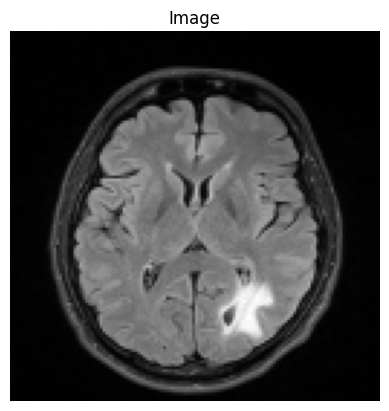

here2
here3
1351 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Pre/00346/NIFTI_Native/flair.nii.gz']


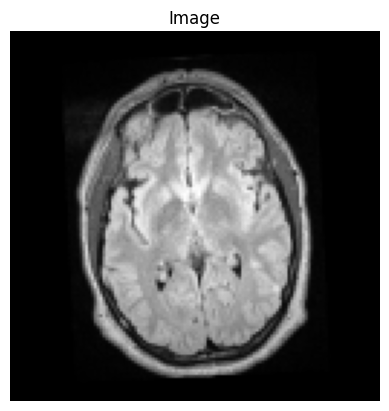

here2
here3
1352 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Atlas_Concatenated/AVAglio/Flair/AVAglio-flair_3710.nii.gz']


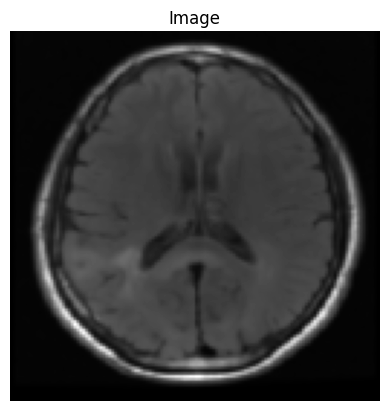

here2
here3
1353 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/00815/NIFTI_Native/flair.nii.gz']


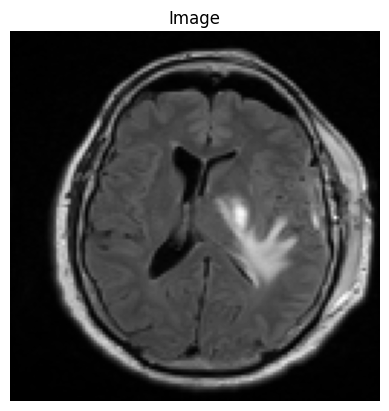

here2
here3
1354 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Atlas_Concatenated/AVAglio/Flair/AVAglio-flair_6954.nii.gz']


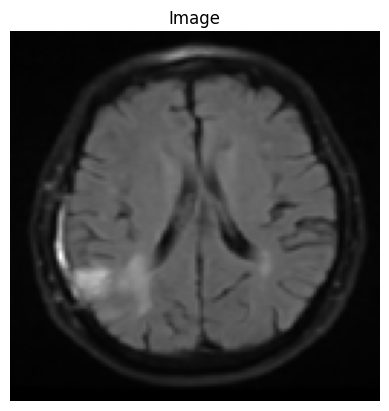

here2
here3
1355 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Pre/03067/NIFTI_Native/flair.nii.gz']


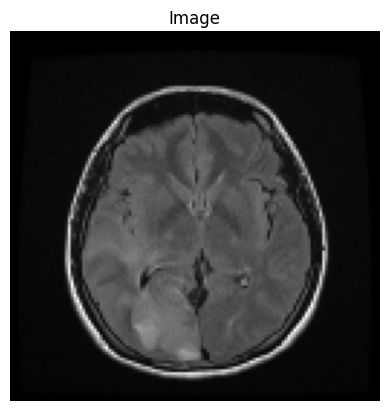

here2
here3
1356 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/00390/NIFTI_Native/flair.nii.gz']


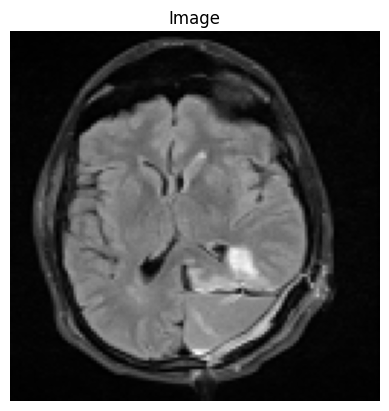

here2
here3
1357 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/01306/NIFTI_Native/flair.nii.gz']


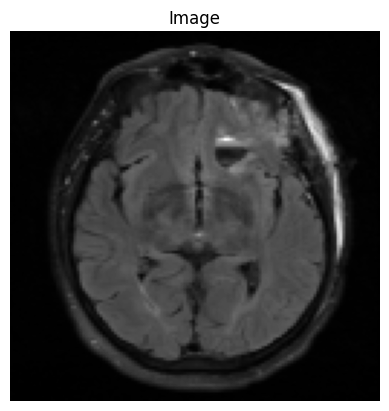

here2
here3
1358 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/01450/NIFTI_Native/flair.nii.gz']


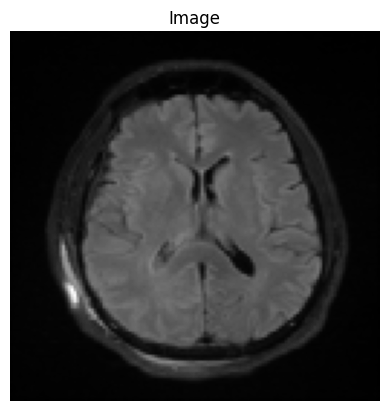

here2
here3
1359 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/02451/NIFTI_Native/flair.nii.gz']


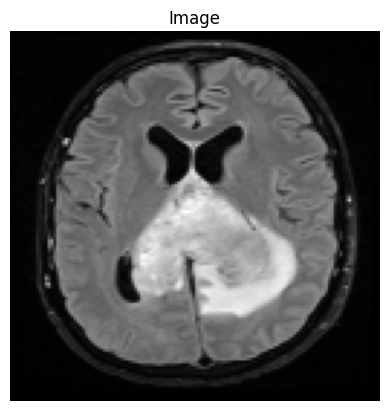

It has been 9.255084753036499 seconds since the loop started


In [8]:
program_starts = time()
step = 1350
print('here1')
for item in check_DataLoader:
    print('here2')
    input_images, label, path= (item["Flair_Image"], item["MGMT"], item["Flair_Path"])
    print('here3')
    try:
        print(f"{step} - input_images shape: {input_images.shape}")
        print(f"Path - {path}")
        plt.title("Image")
        plt.axis('off')
        plt.imshow(np.squeeze(input_images[0,0,:,:,64]), cmap="gray")
        plt.show()
    except:
        print(' ERROR !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

## 2.2 Create Train/Valid/Test DataLoaders

In [9]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=os.cpu_count())

valid_ds = CacheDataset(data=dictionary_valid, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=os.cpu_count())

20


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.48it/s]


## 3. DenseNet Model (for now)

### 3.1 Model and Device Setup


In [10]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = monai.networks.nets.DenseNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)
model.to(device)

# Loss function for each output
loss_function = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-2)

cuda
Let's use 4 GPUs!


#### 3.1.1 Helper Function to Visualize Training Curves

In [11]:
def plot_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure("train", (12, 12))

    plt.subplot(2, 1, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(train_loss))]
    y = train_loss
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [i + 1 for i in range(len(val_loss))]
    y = val_loss
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))


    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    x = [(i + 1) for i in range(len(train_acc))]
    y = train_acc
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [(i + 1) for i in range(len(val_acc))]
    y = val_acc
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))
    
    plt.show()

### 3.2 Training

In [12]:
post_pred = Compose([Activations(softmax=True)])
post_label = Compose([AsDiscrete(to_onehot=2)])


----------
epoch 1/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:35<00:00,  1.11s/it, Overall Training Loss=0.639]


saved new best metric model
current epoch: 1 current avg accuracy: 0.5840 best accuracy: 0.5840 at epoch 1
Num guessed positive: 
245
train accuracy: 0.5428 validation accuracy: 0.5840 train loss: 0.7531 validation loss 3.1400
----------
epoch 2/40


Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s, Overall Training Loss=0.71]


current epoch: 2 current avg accuracy: 0.5600 best accuracy: 0.5840 at epoch 1
Num guessed positive: 
118
train accuracy: 0.5777 validation accuracy: 0.5600 train loss: 0.6900 validation loss 0.6885
----------
epoch 3/40


Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.01it/s, Overall Training Loss=0.66]


current epoch: 3 current avg accuracy: 0.5760 best accuracy: 0.5840 at epoch 1
Num guessed positive: 
194
train accuracy: 0.5498 validation accuracy: 0.5760 train loss: 0.7234 validation loss 0.6826
----------
epoch 4/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.01it/s, Overall Training Loss=0.698]


current epoch: 4 current avg accuracy: 0.5520 best accuracy: 0.5840 at epoch 1
Num guessed positive: 
81
train accuracy: 0.5807 validation accuracy: 0.5520 train loss: 0.6942 validation loss 0.7039
----------
epoch 5/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.01it/s, Overall Training Loss=0.626]


current epoch: 5 current avg accuracy: 0.5360 best accuracy: 0.5840 at epoch 1
Num guessed positive: 
118
train accuracy: 0.5757 validation accuracy: 0.5360 train loss: 0.6807 validation loss 0.8138


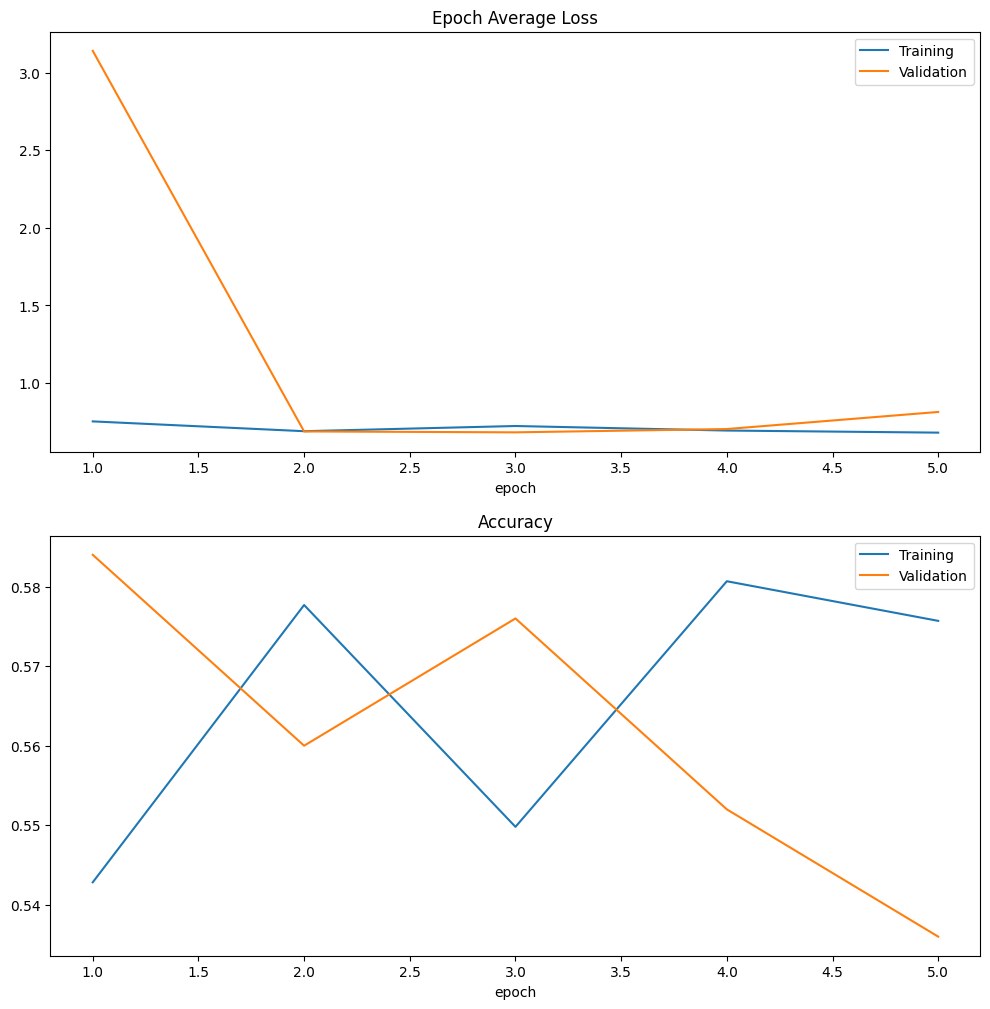

----------
epoch 6/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.01it/s, Overall Training Loss=0.684]


current epoch: 6 current avg accuracy: 0.5840 best accuracy: 0.5840 at epoch 1
Num guessed positive: 
153
train accuracy: 0.5687 validation accuracy: 0.5840 train loss: 0.7007 validation loss 0.6846
----------
epoch 7/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.00it/s, Overall Training Loss=0.673]


current epoch: 7 current avg accuracy: 0.5680 best accuracy: 0.5840 at epoch 1
Num guessed positive: 
42
train accuracy: 0.5717 validation accuracy: 0.5680 train loss: 0.6815 validation loss 0.6874
----------
epoch 8/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.673]


current epoch: 8 current avg accuracy: 0.5600 best accuracy: 0.5840 at epoch 1
Num guessed positive: 
85
train accuracy: 0.5707 validation accuracy: 0.5600 train loss: 0.6849 validation loss 0.7060
----------
epoch 9/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.00s/it, Overall Training Loss=0.743]


current epoch: 9 current avg accuracy: 0.5840 best accuracy: 0.5840 at epoch 1
Num guessed positive: 
168
train accuracy: 0.5578 validation accuracy: 0.5840 train loss: 0.6845 validation loss 0.6961
----------
epoch 10/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.00s/it, Overall Training Loss=0.669]


saved new best metric model
current epoch: 10 current avg accuracy: 0.5920 best accuracy: 0.5920 at epoch 10
Num guessed positive: 
89
train accuracy: 0.5667 validation accuracy: 0.5920 train loss: 0.6797 validation loss 0.7149


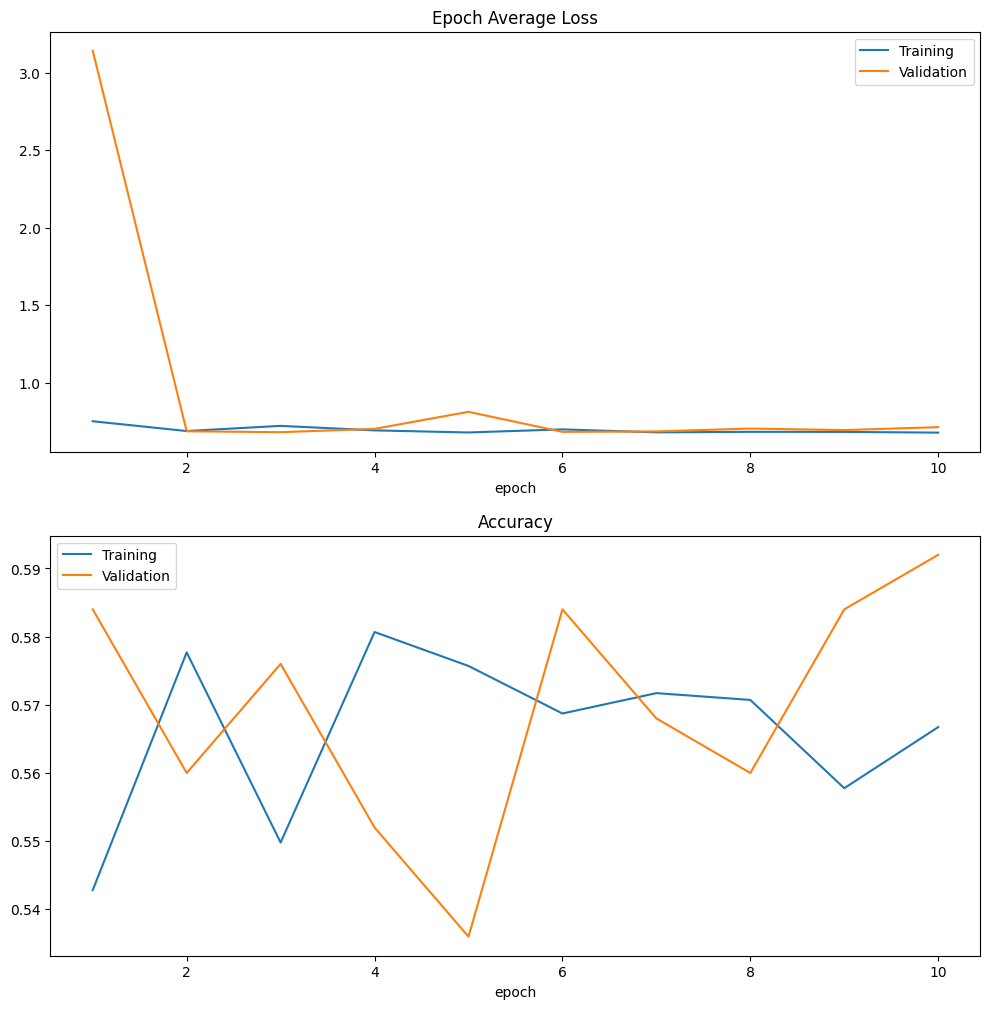

----------
epoch 11/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.00s/it, Overall Training Loss=0.745]


current epoch: 11 current avg accuracy: 0.5840 best accuracy: 0.5920 at epoch 10
Num guessed positive: 
117
train accuracy: 0.5847 validation accuracy: 0.5840 train loss: 0.6811 validation loss 0.6774
----------
epoch 12/40


Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.65]


current epoch: 12 current avg accuracy: 0.5840 best accuracy: 0.5920 at epoch 10
Num guessed positive: 
123
train accuracy: 0.5827 validation accuracy: 0.5840 train loss: 0.6762 validation loss 0.6848
----------
epoch 13/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.669]


current epoch: 13 current avg accuracy: 0.5680 best accuracy: 0.5920 at epoch 10
Num guessed positive: 
175
train accuracy: 0.5707 validation accuracy: 0.5680 train loss: 0.6792 validation loss 0.6697
----------
epoch 14/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.629]


current epoch: 14 current avg accuracy: 0.5840 best accuracy: 0.5920 at epoch 10
Num guessed positive: 
126
train accuracy: 0.5896 validation accuracy: 0.5840 train loss: 0.6713 validation loss 0.6791
----------
epoch 15/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.648]


saved new best metric model
current epoch: 15 current avg accuracy: 0.6000 best accuracy: 0.6000 at epoch 15
Num guessed positive: 
187
train accuracy: 0.5867 validation accuracy: 0.6000 train loss: 0.6723 validation loss 0.6964


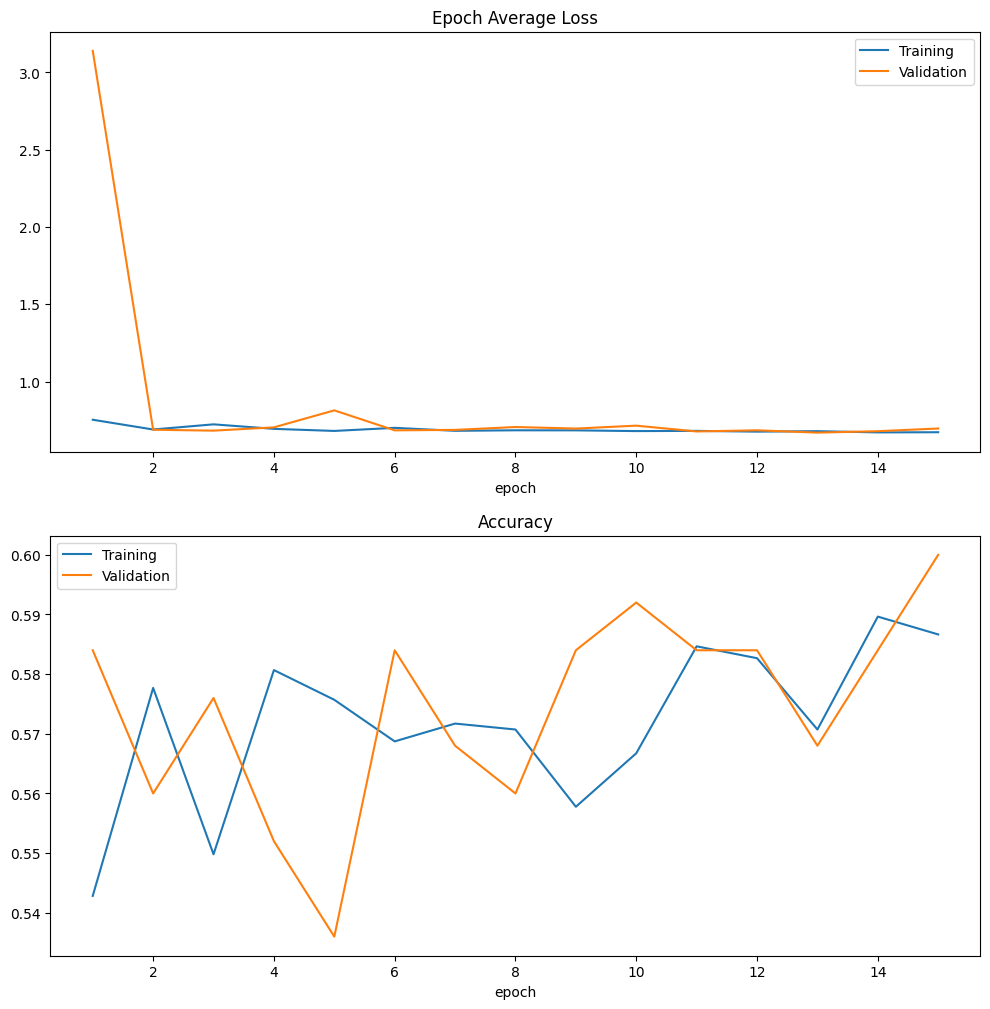

----------
epoch 16/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.649]


current epoch: 16 current avg accuracy: 0.5920 best accuracy: 0.6000 at epoch 15
Num guessed positive: 
228
train accuracy: 0.5916 validation accuracy: 0.5920 train loss: 0.6766 validation loss 0.6900
----------
epoch 17/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.668]


current epoch: 17 current avg accuracy: 0.5760 best accuracy: 0.6000 at epoch 15
Num guessed positive: 
207
train accuracy: 0.5867 validation accuracy: 0.5760 train loss: 0.6792 validation loss 0.6791
----------
epoch 18/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.568]


current epoch: 18 current avg accuracy: 0.5760 best accuracy: 0.6000 at epoch 15
Num guessed positive: 
142
train accuracy: 0.5857 validation accuracy: 0.5760 train loss: 0.6632 validation loss 0.6952
----------
epoch 19/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.00s/it, Overall Training Loss=0.644]


saved new best metric model
current epoch: 19 current avg accuracy: 0.6320 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
208
train accuracy: 0.5976 validation accuracy: 0.6320 train loss: 0.6697 validation loss 0.6746
----------
epoch 20/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.805]


current epoch: 20 current avg accuracy: 0.6160 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
200
train accuracy: 0.6116 validation accuracy: 0.6160 train loss: 0.6664 validation loss 0.6833


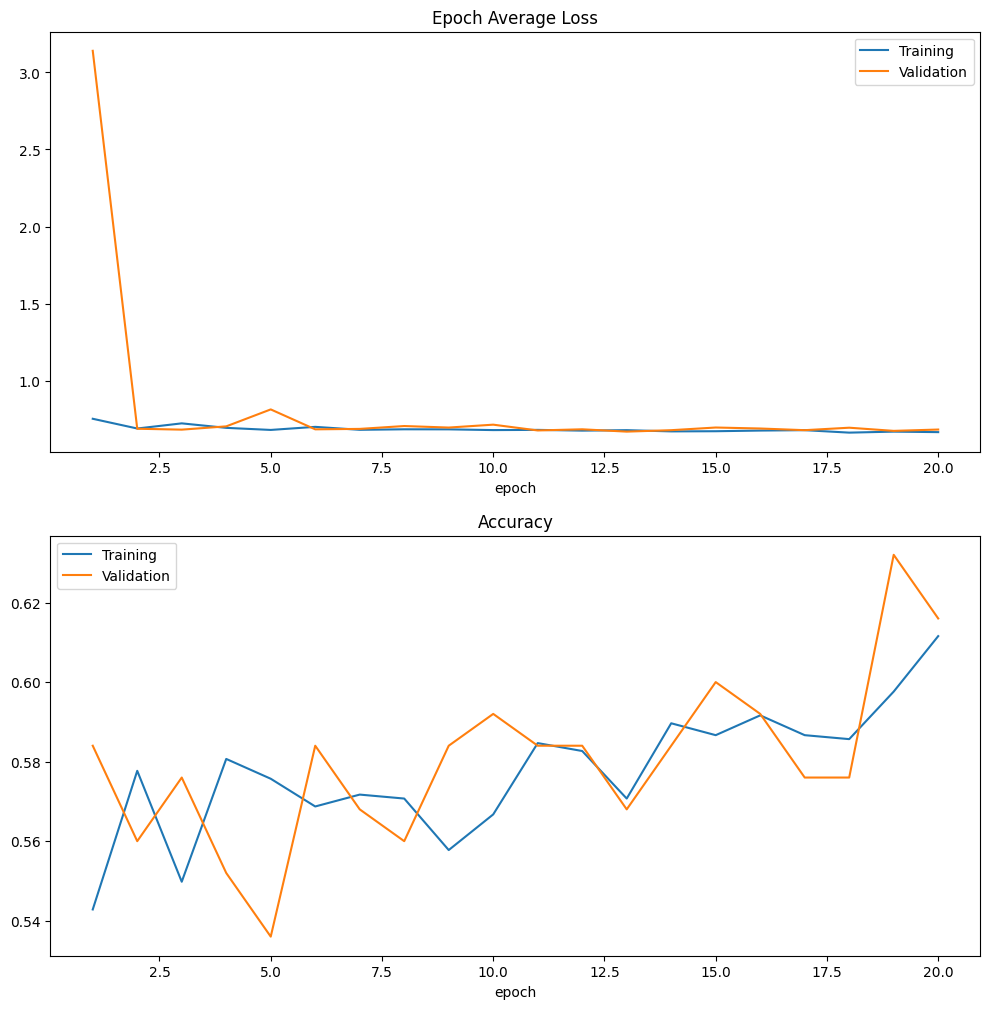

----------
epoch 21/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.787]


current epoch: 21 current avg accuracy: 0.5760 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
265
train accuracy: 0.6006 validation accuracy: 0.5760 train loss: 0.6705 validation loss 0.6868
----------
epoch 22/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.554]


current epoch: 22 current avg accuracy: 0.5280 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
249
train accuracy: 0.6086 validation accuracy: 0.5280 train loss: 0.6632 validation loss 0.7131
----------
epoch 23/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.607]


current epoch: 23 current avg accuracy: 0.6160 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
176
train accuracy: 0.5996 validation accuracy: 0.6160 train loss: 0.6612 validation loss 0.6880
----------
epoch 24/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.652]


current epoch: 24 current avg accuracy: 0.5840 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
265
train accuracy: 0.6066 validation accuracy: 0.5840 train loss: 0.6575 validation loss 0.6879
----------
epoch 25/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.731]


current epoch: 25 current avg accuracy: 0.5600 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
263
train accuracy: 0.5906 validation accuracy: 0.5600 train loss: 0.6664 validation loss 0.6890


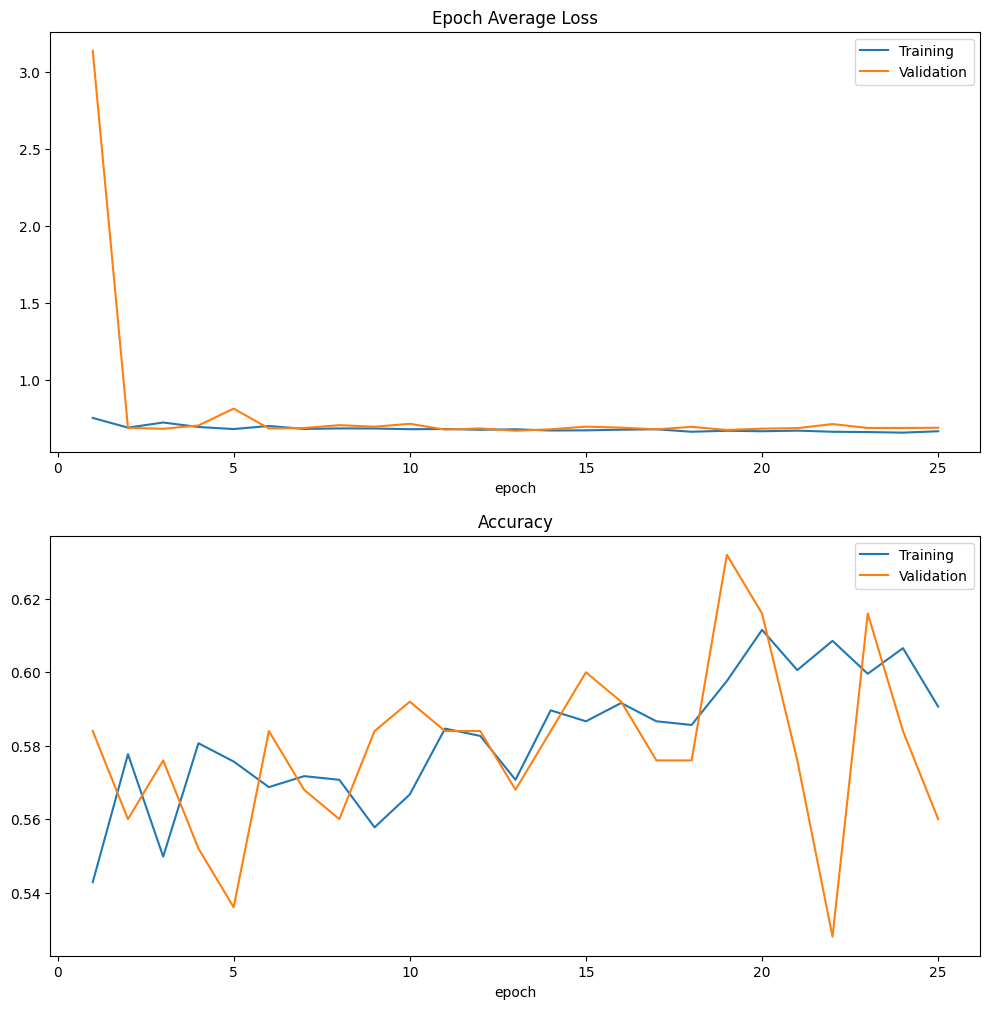

----------
epoch 26/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.669]


current epoch: 26 current avg accuracy: 0.5600 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
228
train accuracy: 0.6155 validation accuracy: 0.5600 train loss: 0.6561 validation loss 0.6877
----------
epoch 27/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.03s/it, Overall Training Loss=0.562]


current epoch: 27 current avg accuracy: 0.5040 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
304
train accuracy: 0.6195 validation accuracy: 0.5040 train loss: 0.6532 validation loss 0.7312
----------
epoch 28/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.763]


current epoch: 28 current avg accuracy: 0.5440 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
309
train accuracy: 0.6384 validation accuracy: 0.5440 train loss: 0.6473 validation loss 0.7427
----------
epoch 29/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.671]


current epoch: 29 current avg accuracy: 0.5760 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
332
train accuracy: 0.6155 validation accuracy: 0.5760 train loss: 0.6569 validation loss 0.6873
----------
epoch 30/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.709]


current epoch: 30 current avg accuracy: 0.5360 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
232
train accuracy: 0.6235 validation accuracy: 0.5360 train loss: 0.6477 validation loss 0.6990


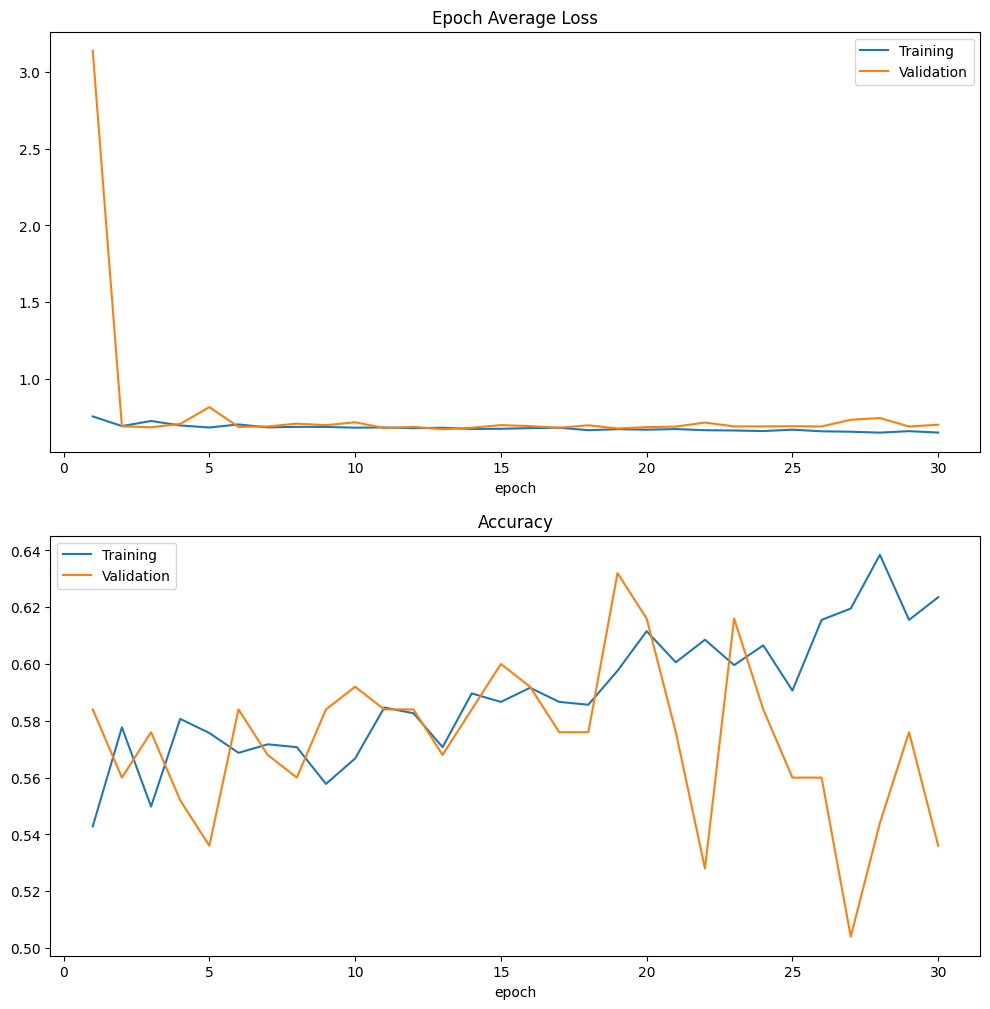

----------
epoch 31/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.743]


current epoch: 31 current avg accuracy: 0.4400 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
352
train accuracy: 0.6355 validation accuracy: 0.4400 train loss: 0.6488 validation loss 0.7420
----------
epoch 32/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.615]


current epoch: 32 current avg accuracy: 0.4960 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
288
train accuracy: 0.6255 validation accuracy: 0.4960 train loss: 0.6489 validation loss 0.7153
----------
epoch 33/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.00s/it, Overall Training Loss=0.643]


current epoch: 33 current avg accuracy: 0.4960 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
359
train accuracy: 0.6265 validation accuracy: 0.4960 train loss: 0.6459 validation loss 0.7261
----------
epoch 34/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.617]


current epoch: 34 current avg accuracy: 0.4720 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
313
train accuracy: 0.6125 validation accuracy: 0.4720 train loss: 0.6548 validation loss 0.7175
----------
epoch 35/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.573]


current epoch: 35 current avg accuracy: 0.5760 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
277
train accuracy: 0.6345 validation accuracy: 0.5760 train loss: 0.6365 validation loss 0.7307


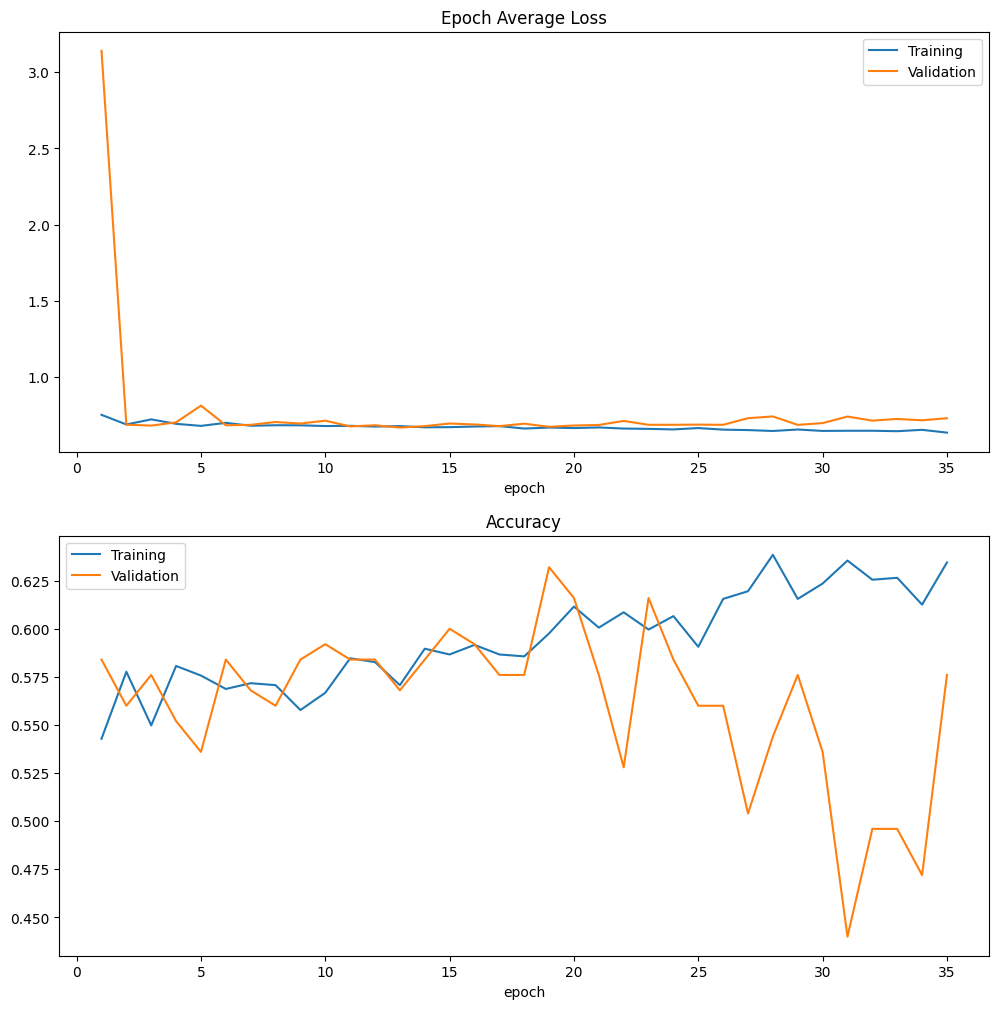

----------
epoch 36/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.542]


current epoch: 36 current avg accuracy: 0.6160 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
365
train accuracy: 0.6265 validation accuracy: 0.6160 train loss: 0.6491 validation loss 0.7192
----------
epoch 37/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it, Overall Training Loss=0.634]


current epoch: 37 current avg accuracy: 0.5920 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
326
train accuracy: 0.6633 validation accuracy: 0.5920 train loss: 0.6256 validation loss 0.8140
----------
epoch 38/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.661]


current epoch: 38 current avg accuracy: 0.5680 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
340
train accuracy: 0.6434 validation accuracy: 0.5680 train loss: 0.6170 validation loss 0.7582
----------
epoch 39/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.629]


current epoch: 39 current avg accuracy: 0.5520 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
360
train accuracy: 0.6693 validation accuracy: 0.5520 train loss: 0.6152 validation loss 0.7420
----------
epoch 40/40


Epoch : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.01s/it, Overall Training Loss=0.571]


current epoch: 40 current avg accuracy: 0.5920 best accuracy: 0.6320 at epoch 19
Num guessed positive: 
365
train accuracy: 0.6743 validation accuracy: 0.5920 train loss: 0.5995 validation loss 0.7057


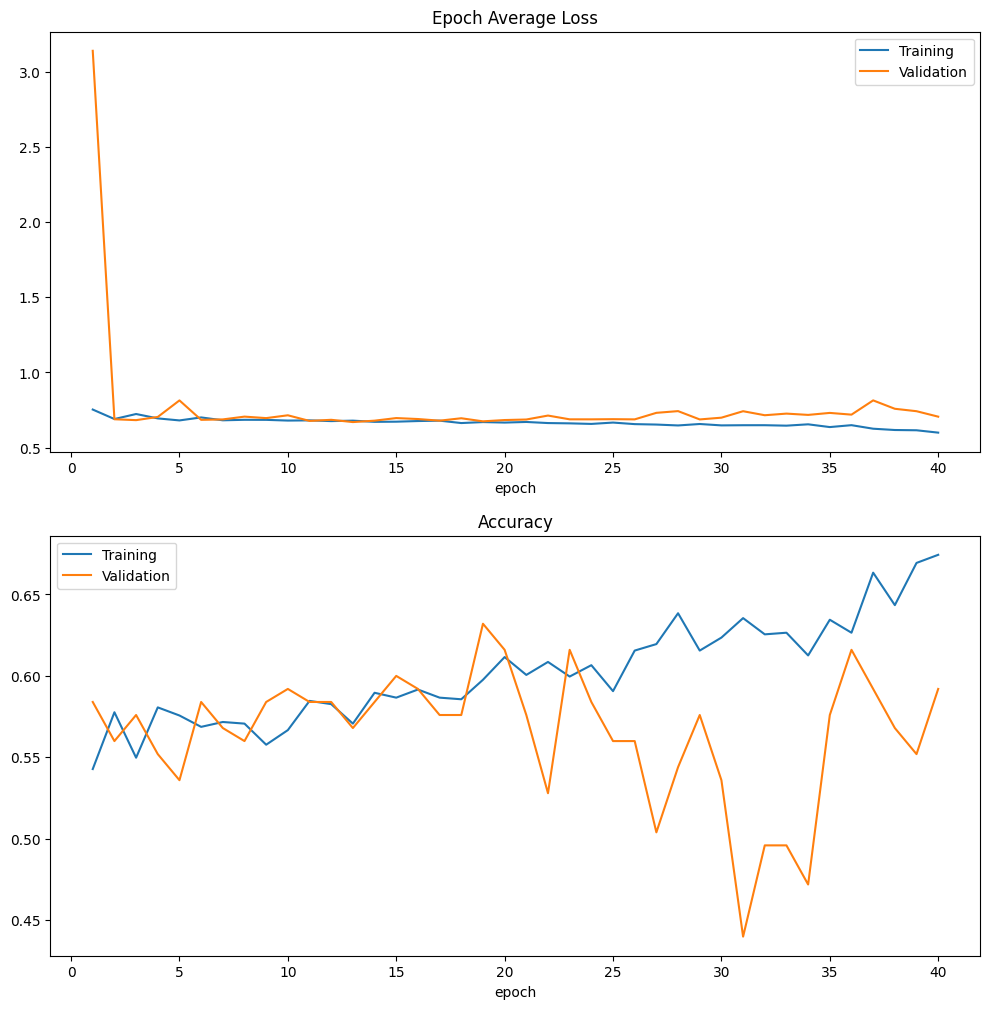

train completed, best_metric: 0.6320 at epoch: 19


In [13]:
val_interval = 1    # validate at every n epochs
graph_interval = 5    # plot training graphs every n epochs

best_metric = -1    # default value
best_metric_epoch = -1    # default value

# arrays to keep track of loss and accuracy for plotting curves
train_loss = []
val_loss = []
train_acc = []
val_acc = []


train_acc = []
val_acc = []

num_epochs = 40

torch.cuda.empty_cache()

for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    # Helper variables to calculate accuracy (num_correct / metric_count)
    # 1 - Class, 2 - Dimension, 3 - Orientation
    num_correct = 0.0
    metric_count = 0
    num_guessed_positive = 0
    
    # TRAINING
    # using tqdm will show progress bar for each epoch
    with tqdm(train_loader, desc=("Epoch ")) as pbar:
        # iterate through train_loader batches
        for i, batch_data in enumerate(pbar):
            step += 1
            image, labels = torch.cat((batch_data["Flair_Image"].to(device, dtype=torch.float), batch_data["Flair_Mask_Image"].to(device, dtype=torch.float)), dim=1), torch.from_numpy(np.asarray(batch_data["MGMT"]).astype('int64')).to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            
            # values for calculating accuracy
            threshold = torch.tensor([0.5]).to(device)
            num_guessed_positive += (torch.sigmoid(output) > threshold).sum().item()
            value = torch.eq((torch.sigmoid(output) > threshold).float()*1, labels)
            metric_count += len(value)
            num_correct += value.sum().item()    
            
            # epoch loss
            epoch_loss += loss.item()
                                                                                      
            epoch_len = len(train_ds) // train_loader.batch_size
            
            # update progress bar to display loss
            pbar.set_postfix({'Overall Training Loss': loss.item()})
            
        # append loss and accuracy
        epoch_loss /= step
        train_loss.append(epoch_loss)
        metric = num_correct / metric_count
        train_acc.append(metric)
    
        # VALIDATION
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():

                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                                                                
                
                # iterate through valid_loader batches
                for i, val_data in enumerate(valid_loader):
                    val_flair, val_flair_mask, val_labels = val_data["Flair_Image"].to(device, dtype=torch.float), val_data["Flair_Mask_Image"].to(device, dtype=torch.float), torch.from_numpy(np.asarray(val_data["MGMT"]).astype('int64')).to(device)
                    output = model(torch.cat((val_flair, val_flair_mask), dim=1))
                    y_pred = torch.cat([y_pred, output], dim=0)
                    y = torch.cat([y, val_labels], dim=0)
                    
                # calculate and append loss
                loss = loss_function(y_pred, y.float().unsqueeze(1))
                val_loss.append(loss.item())


                
                # calculate and append accuracy
                threshold = torch.tensor([0.5]).to(device)
                acc_value = torch.eq((torch.sigmoid(y_pred) > threshold).float()*1, y.float().unsqueeze(1))
                acc_metric = (acc_value.sum().item()) / len(acc_value)
                val_acc.append(acc_metric)


                # update best metric
                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        'train_loss_arr': train_loss,
                        'val_loss_arr': val_loss,
                        'train_acc_arr': train_acc,
                        'val_acc_arr': val_acc,
                        'val_acc': val_acc,
                        'train_acc': train_acc,
                        }, "best_metric_densenet.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current avg accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, acc_metric, best_metric, best_metric_epoch
                    )
                )
                print("Num guessed positive: ")
                print(num_guessed_positive)
                print(
                    "train accuracy: {:.4f} validation accuracy: {:.4f} train loss: {:.4f} validation loss {:.4f}".format(
                        train_acc[-1], acc_metric, train_loss[-1],loss.item()
                    )
                )
                
        # display train/validation curves
        if (epoch + 1) % graph_interval == 0:
            plot_curves(train_loss, val_loss, train_acc, val_acc)
        
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

## 4. Evaluating Results

### 4.1 Evaluating the Model on the Test Dataset

In [14]:
saved_dict = torch.load("best_metric_densenet.pth")
model.load_state_dict(saved_dict['model_state_dict'])
model.eval()
y_true = []
y_pred = []
y_probs = []


with tqdm(test_loader, desc=("Loading ")) as pbar:
    with torch.no_grad():
        for test_data in pbar:
            test_images, test_labels = (
                torch.cat((test_data["Flair_Image"].to(device, dtype=torch.float), test_data["Flair_Mask_Image"].to(device, dtype=torch.float)), dim=1), 
                torch.from_numpy(np.asarray(test_data["MGMT"]).astype('int64')).to(device)
            )

            output = torch.sigmoid(model(test_images))
            print(output)
            probs = (output > 0.5)

            y_probs.extend(probs)

            for i in range(len(output)):
                y_true.append(test_labels[i].item())
                y_pred.append(probs[i].item())


Loading :  25%|███████████████████████████████████▎                                                                                                         | 1/4 [00:07<00:21,  7.32s/it]

tensor([[0.5606],
        [0.4008],
        [0.2805],
        [0.6114],
        [0.4368],
        [0.3323],
        [0.3267],
        [0.3194],
        [0.4156],
        [0.3745],
        [0.7969],
        [0.5095],
        [0.4891],
        [0.4291],
        [0.6644],
        [0.3405],
        [0.4349],
        [0.2709],
        [0.2959],
        [0.5709],
        [0.4668],
        [0.4846],
        [0.2980],
        [0.2676],
        [0.3914],
        [0.3138],
        [0.4661],
        [0.4945],
        [0.3274],
        [0.3855],
        [0.2794],
        [0.5296]], device='cuda:0')


Loading :  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 2/4 [00:07<00:06,  3.27s/it]

tensor([[0.5450],
        [0.3920],
        [0.6308],
        [0.5306],
        [0.7916],
        [0.3375],
        [0.4988],
        [0.3142],
        [0.2458],
        [0.5226],
        [0.3978],
        [0.5479],
        [0.4401],
        [0.3080],
        [0.5158],
        [0.2824],
        [0.6433],
        [0.3390],
        [0.3624],
        [0.3815],
        [0.5141],
        [0.4957],
        [0.5129],
        [0.3996],
        [0.5757],
        [0.4550],
        [0.4717],
        [0.3171],
        [0.3190],
        [0.4062],
        [0.3205],
        [0.5315]], device='cuda:0')


Loading :  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3/4 [00:08<00:01,  1.97s/it]

tensor([[0.4288],
        [0.5841],
        [0.3617],
        [0.5152],
        [0.4330],
        [0.4450],
        [0.4028],
        [0.2774],
        [0.5051],
        [0.2664],
        [0.2506],
        [0.3747],
        [0.3008],
        [0.4535],
        [0.2869],
        [0.2820],
        [0.2468],
        [0.6707],
        [0.7793],
        [0.4554],
        [0.3893],
        [0.4671],
        [0.3970],
        [0.5798],
        [0.2961],
        [0.2651],
        [0.3533],
        [0.4264],
        [0.4929],
        [0.2813],
        [0.4626],
        [0.3709]], device='cuda:0')


Loading : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  1.46s/it]

tensor([[0.5243],
        [0.2915],
        [0.2943],
        [0.4677],
        [0.3233],
        [0.5350],
        [0.4821],
        [0.3797],
        [0.5175],
        [0.3934],
        [0.2870],
        [0.5015],
        [0.5538],
        [0.2894],
        [0.3642],
        [0.4692],
        [0.4427],
        [0.4198],
        [0.4771],
        [0.4129],
        [0.3377],
        [0.3223],
        [0.4215],
        [0.2931],
        [0.3024],
        [0.6632],
        [0.4180],
        [0.4098],
        [0.2737]], device='cuda:0')


Loading : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.43s/it]


#### 4.1.2 Classification Report

In [15]:
print(metrics.classification_report(y_true, y_pred, target_names=["UNMETHYLATED", "METHYLATED"], digits=4))

              precision    recall  f1-score   support

UNMETHYLATED     0.5745    0.7500    0.6506        72
  METHYLATED     0.4194    0.2453    0.3095        53

    accuracy                         0.5360       125
   macro avg     0.4969    0.4976    0.4801       125
weighted avg     0.5087    0.5360    0.5060       125



#### 4.1.3 Confusion Matrix

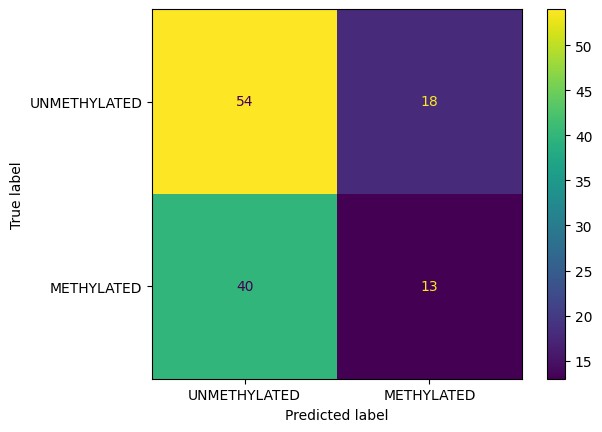

In [16]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["UNMETHYLATED", "METHYLATED"])
cm_display.plot()
plt.show()

In [1]:
# Slightly better than before...

%reset -f